In [1]:
# (optional) !pip install -U scikit-learn scipy pandas numpy matplotlib

import numpy as np
import pandas as pd
from scipy.sparse import vstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.utils import resample
from scipy.stats import norm
import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Use existing dataset and label column
CSV_PATH = "EduPilot_dataset.csv"  # or "EduPilot_dataset_2000.csv"
LABEL_COL = "interview_round"
df = pd.read_csv(CSV_PATH)
df = df.dropna(subset=[LABEL_COL])
label_words = sorted(df[LABEL_COL].unique())
label_to_id = {w: i for i, w in enumerate(label_words)}
y = df[LABEL_COL].map(label_to_id).astype(int).values

# Build a simple text feature by concatenating fields
text_cols = ["user_query", "job_role", "company", "location", "mock_question"]
df["text"] = df[text_cols].fillna("").agg(" | ".join, axis=1)
vec = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
X = vec.fit_transform(df["text"])


In [2]:
# Adjust the path/filename as needed
CSV_PATH = "EduPilot_dataset.csv"  # or "EduPilot_dataset_2000.csv"
df = pd.read_csv(CSV_PATH)

# Ensure target exists and map to integers 0..4 using your fixed label set
df = df.dropna(subset=["interview_round"])
y = df["interview_round"].map(label_to_id)
assert y.notna().all(), "Found interview_round values not in label_words; update label_words or clean the data."
y = y.astype(int).values

# Build a simple text feature by concatenating fields
text_cols = ["user_query", "job_role", "company", "location", "mock_question"]
df["text"] = df[text_cols].fillna("").agg(" | ".join, axis=1)

# TF-IDF vectorizer (tweak max_features if you like)
vec = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
X = vec.fit_transform(df["text"])

# Victim split: train/test
X_tr_all, X_te_all, y_tr_all, y_te_all = train_test_split(
    X, y, test_size=0.40, stratify=y, random_state=RANDOM_SEED
)

# Keep a holdout from the training slice for the shadow pool
X_tr, X_hold, y_tr, y_hold = train_test_split(
    X_tr_all, y_tr_all, test_size=0.25, stratify=y_tr_all, random_state=RANDOM_SEED + 1
)

X_tr.shape, X_hold.shape, X_te_all.shape


((54, 476), (18, 476), (48, 476))

In [3]:
# Use defaults to avoid deprecation warnings; multiclass handled automatically.
victim = LogisticRegression(max_iter=300, n_jobs=None)
victim.fit(X_tr, y_tr)

def per_example_loss(model, Xmat, y_true, eps=1e-12):
    """
    Negative log prob of the TRUE class for each example.
    """
    proba = model.predict_proba(Xmat)                      # [n, n_classes]
    rows = np.arange(Xmat.shape[0])
    p_true = np.clip(proba[rows, y_true], eps, 1.0 - eps)  # true-class prob
    return -np.log(p_true)

# Quick check: member vs non-member losses on the victim
loss_members     = per_example_loss(victim, X_tr,     y_tr)
loss_nonmembers  = per_example_loss(victim, X_te_all, y_te_all)

print("Victim mean loss (members)   :", float(loss_members.mean()))
print("Victim mean loss (nonmembers):", float(loss_nonmembers.mean()))


Victim mean loss (members)   : 0.6948289760763008
Victim mean loss (nonmembers): 0.935124984987338


In [4]:
# Build a pool NOT used for victim training (holdout + test)
from scipy.sparse import vstack
X_pool = vstack([X_hold, X_te_all])
y_pool = np.concatenate([y_hold, y_te_all])

# Train K shadow LR models on bootstraps from the same distribution
K = 20
shadow_member_losses, shadow_nonmember_losses = [], []

for k in range(K):
    # bootstrap indices
    idx = np.arange(X_pool.shape[0])
    tr_idx = resample(idx, n_samples=int(0.6*len(idx)), replace=True, random_state=1000+k)
    te_idx = resample(idx, n_samples=int(0.4*len(idx)), replace=True, random_state=2000+k)

    Xs_tr, ys_tr = X_pool[tr_idx], y_pool[tr_idx]
    Xs_te, ys_te = X_pool[te_idx], y_pool[te_idx]

    sh = LogisticRegression(max_iter=300, solver="liblinear", multi_class="ovr")
    sh.fit(Xs_tr, ys_tr)

    shadow_member_losses.extend(per_example_loss(sh, Xs_tr, ys_tr))
    shadow_nonmember_losses.extend(per_example_loss(sh, Xs_te, ys_te))

shadow_member_losses = np.array(shadow_member_losses)
shadow_nonmember_losses = np.array(shadow_nonmember_losses)

print("Shadow member loss μ±σ: ",
      shadow_member_losses.mean(), shadow_member_losses.std())
print("Shadow non-member loss μ±σ:",
      shadow_nonmember_losses.mean(), shadow_nonmember_losses.std())


Shadow member loss μ±σ:  0.8545756493274896 0.1880733175861088
Shadow non-member loss μ±σ: 1.0856652137655427 0.34440868373597094


/Users/amitkumar/PycharmProjects/EduPilot/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/amitkumar/PycharmProjects/EduPilot/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/amitkumar/PycharmProjects/EduPilot/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. L

In [5]:
# Pool for shadows = victim holdout + victim test (unseen by victim training)
X_pool = vstack([X_hold, X_te_all])
y_pool = np.concatenate([y_hold, y_te_all])

K_SHADOWS = 20  # increase to 50–100 for smoother fits if compute allows
SAMPLE_FRAC_TRAIN = 0.60
SAMPLE_FRAC_TEST  = 0.40

shadow_member_losses = []
shadow_nonmember_losses = []

pool_idx = np.arange(X_pool.shape[0])

for k in range(K_SHADOWS):
    # Bootstrap indices for shadow train/test from the same distribution
    tr_idx = resample(pool_idx, n_samples=int(SAMPLE_FRAC_TRAIN * len(pool_idx)),
                      replace=True, random_state=1000 + k)
    te_idx = resample(pool_idx, n_samples=int(SAMPLE_FRAC_TEST * len(pool_idx)),
                      replace=True, random_state=2000 + k)
    Xs_tr, ys_tr = X_pool[tr_idx], y_pool[tr_idx]
    Xs_te, ys_te = X_pool[te_idx], y_pool[te_idx]

    sh = LogisticRegression(max_iter=300)
    sh.fit(Xs_tr, ys_tr)

    shadow_member_losses.extend(per_example_loss(sh, Xs_tr, ys_tr))
    shadow_nonmember_losses.extend(per_example_loss(sh, Xs_te, ys_te))

shadow_member_losses = np.array(shadow_member_losses, dtype=float)
shadow_nonmember_losses = np.array(shadow_nonmember_losses, dtype=float)

print("Shadow member loss  μ±σ:", float(shadow_member_losses.mean()), float(shadow_member_losses.std()))
print("Shadow non-mem loss μ±σ:", float(shadow_nonmember_losses.mean()), float(shadow_nonmember_losses.std()))


Shadow member loss  μ±σ: 0.6807085580394653 0.2252036043821907
Shadow non-mem loss μ±σ: 0.9756765382199389 0.4445568833921572


In [7]:
# Fit Gaussians to shadow distributions
mem_mu,  mem_sig  = shadow_member_losses.mean(),  max(shadow_member_losses.std(), 1e-6)
non_mu,  non_sig  = shadow_nonmember_losses.mean(), max(shadow_nonmember_losses.std(), 1e-6)

# Build evaluation set: members = victim train, nonmembers = victim test
X_eval = vstack([X_tr, X_te_all])
y_eval_is_member = np.concatenate([np.ones(len(y_tr)), np.zeros(len(y_te_all))]).astype(int)

# Victim per-example losses on eval
loss_eval = np.concatenate([
    per_example_loss(victim, X_tr,     y_tr),
    per_example_loss(victim, X_te_all, y_te_all)
])

# LiRA score = log N(loss | member) - log N(loss | non-member)
logp_mem = norm.logpdf(loss_eval, loc=mem_mu, scale=mem_sig)
logp_non = norm.logpdf(loss_eval, loc=non_mu, scale=non_sig)
lira_scores = logp_mem - logp_non

# Baseline: loss-threshold (use -loss as the score)
thresh_scores = -loss_eval

# Metrics
auc_lira   = roc_auc_score(y_eval_is_member, lira_scores)
auc_thresh = roc_auc_score(y_eval_is_member, thresh_scores)

def tpr_at_fpr(y_true, scores, fpr_target):
    fpr, tpr, thr = roc_curve(y_true, scores)
    if np.max(fpr) < fpr_target:
        return float(tpr[np.argmax(tpr)])
    i = np.searchsorted(fpr, fpr_target, side="right")
    if i == 0:
        return float(tpr[0])
    f0, t0, f1, t1 = fpr[i-1], tpr[i-1], fpr[i], tpr[i]
    if f1 == f0:
        return float(t1)
    w = (fpr_target - f0) / (f1 - f0)
    return float(t0 + w * (t1 - t0))

print(f"AUC  LiRA    : {auc_lira:.4f}")
print(f"AUC  Threshold: {auc_thresh:.4f}")
for f in [0.001, 0.01, 0.10]:
    print(f"TPR@FPR={int(f*1000)/10:.1f}%  LiRA={tpr_at_fpr(y_eval_is_member, lira_scores, f):.4f}  "
          f"Thresh={tpr_at_fpr(y_eval_is_member, thresh_scores, f):.4f}")


AUC  LiRA    : 0.8121
AUC  Threshold: 0.8245
TPR@FPR=0.1%  LiRA=0.0000  Thresh=0.1667
TPR@FPR=1.0%  LiRA=0.0000  Thresh=0.1667
TPR@FPR=10.0%  LiRA=0.4259  Thresh=0.4444


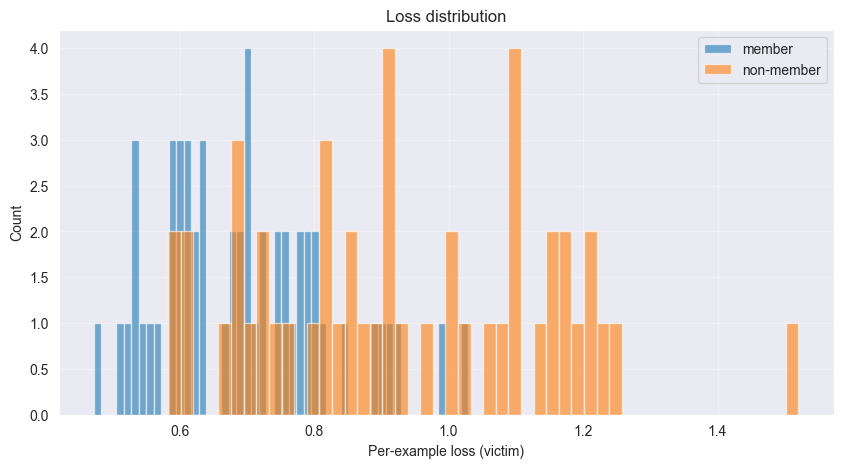

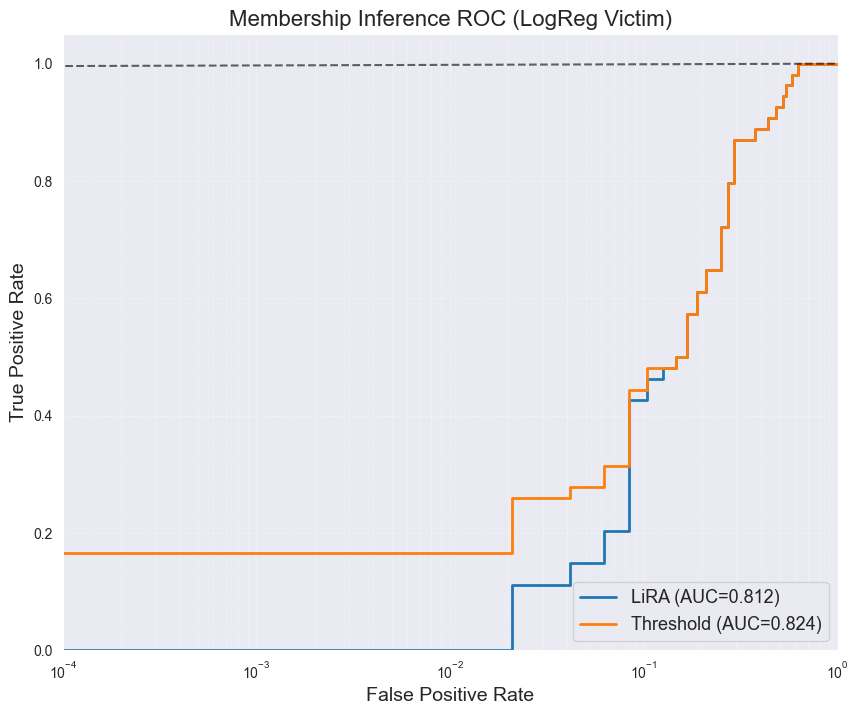

In [8]:
# Loss histograms for victim (members vs non-members)
plt.figure(figsize=(10, 5))
plt.hist(loss_members,    bins=50, alpha=0.6, label="member")
plt.hist(loss_nonmembers, bins=50, alpha=0.6, label="non-member")
plt.xlabel("Per-example loss (victim)"); plt.ylabel("Count"); plt.title("Loss distribution")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

# ROC curves (LiRA vs Threshold) — correct AUC + bigger figure
from sklearn.metrics import roc_curve, roc_auc_score

fpr_l, tpr_l, _ = roc_curve(y_eval_is_member, lira_scores)
fpr_t, tpr_t, _ = roc_curve(y_eval_is_member, thresh_scores)

auc_l = roc_auc_score(y_eval_is_member, lira_scores)
auc_t = roc_auc_score(y_eval_is_member, thresh_scores)

plt.figure(figsize=(10, 8))
plt.plot(fpr_l, tpr_l, linewidth=2.0, label=f"LiRA (AUC={auc_l:.3f})")
plt.plot(fpr_t, tpr_t, linewidth=2.0, label=f"Threshold (AUC={auc_t:.3f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)

# use linear first to sanity-check the curve; switch to log if desired
# plt.xscale("linear"); plt.xlim(0.0, 1.0)
plt.xscale("log"); plt.xlim(1e-4, 1.0)  # comment this line if you prefer linear
plt.ylim(0.0, 1.05)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Membership Inference ROC (LogReg Victim)", fontsize=16)
plt.grid(True, which="both", linestyle=":", alpha=0.6)
plt.legend(fontsize=13, loc="lower right")
plt.show()
